## Trend Scanning meta label example

This is an example of how we use the `TrendScanning` class.

There is really no trivial way to optmize the look forward period: for instance, if we create a sort of Monte Carlo optmization, defining a number of times we want to iterate, the maximum t-values we end up with don't get the trend right.

Instead, we opted for a heuristic optimization: we test a bunch of look-forward periods and see which best captures the trend or lack of trend.

In this notebook we also normalize the t-values found using a min-max function, so that we can have $t \in \{-1, 0, 1\} labels for our machine learning training.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from trend import TrendScanning

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [2]:
df = pd.read_csv('win_may_18.csv')

In [3]:
df.time = pd.to_datetime(df.time)

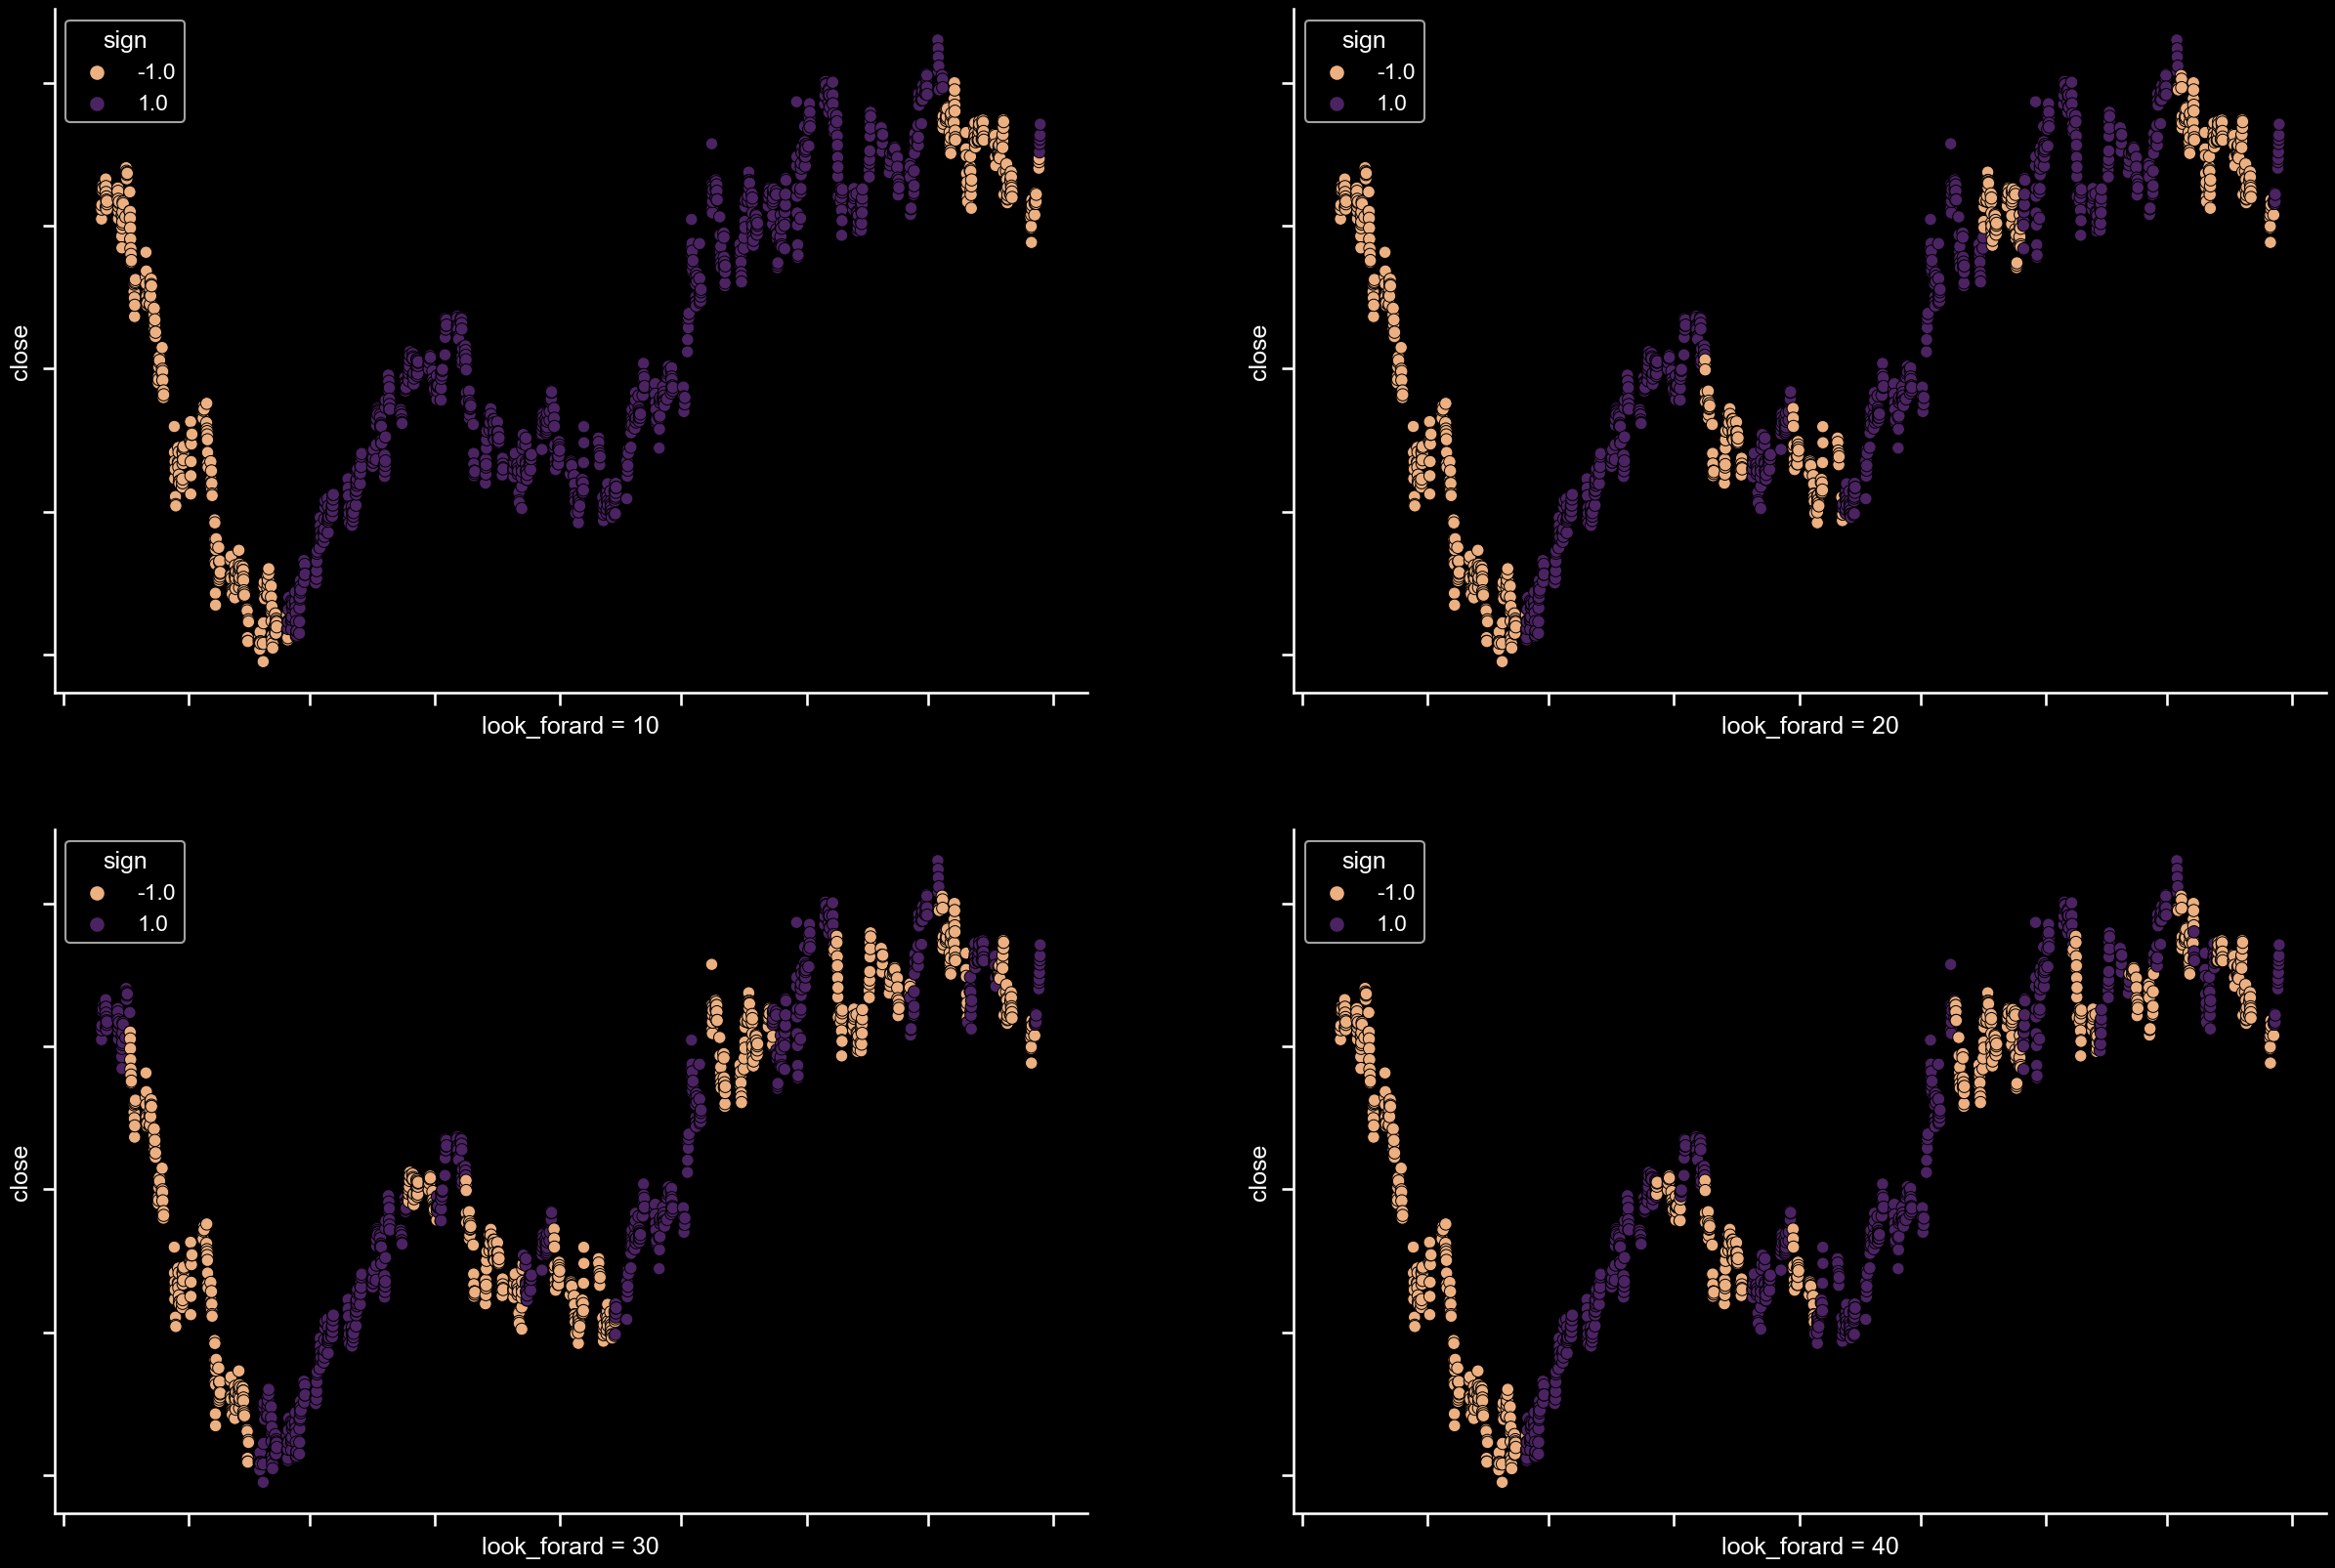

In [4]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

axis_n = [ax1, ax2, ax3, ax4]
look_forwards = [10, 20, 30, 40]

for axis, lf in zip(axis_n, look_forwards):

    trend = TrendScanning(df, lf)
    df = df.assign(sign = trend.trend_scan.sign)
    df = df.assign(t_value = trend.trend_scan.t_val)

    sns.scatterplot(x=df.time, y=df.close, hue=df.sign, palette="flare",
                    edgecolor='black', ax=axis)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
    axis.set(xlabel=f'look_forard = {lf}')

sns.despine(right=True)
plt.savefig('trend_scanning.png')
plt.show()

From these choices we pick `look_forward = 10`, since it looks like the one that would produce the least noise in some out-of-sample time series.

In [5]:
trend = TrendScanning(df, 10)
df = df.assign(sign = trend.trend_scan.sign)
df = df.assign(t_value = trend.trend_scan.t_val)

In [6]:
def normalize(l):
    l_min = l.min()
    l_max = l.max()

    return 2*(l - l_min)/(l_max - l_min) - 1

In [7]:
df['t_n'] = normalize(df.t_value)

df['t'] = 0

df['t'] = np.where(df.t_n <= df.t_n.quantile(.25), -1, df.t)
df['t'] = np.where(df.t_n >= df.t_n.quantile(.75), 1, df.t)

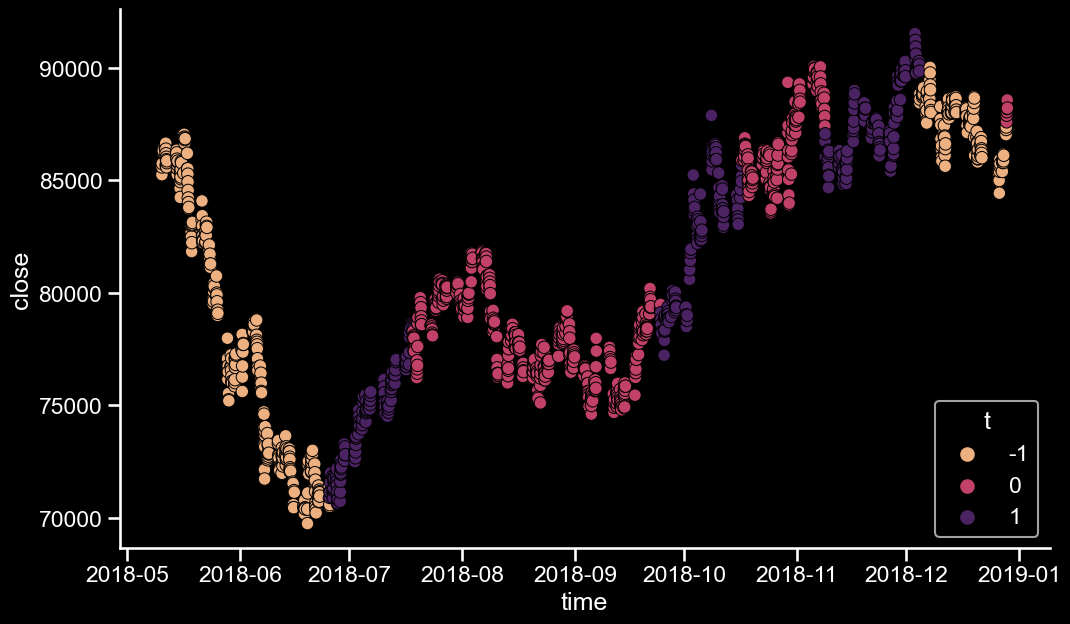

In [8]:
fig, ax = plt.subplots(figsize=(12,7))

sns.scatterplot(x=df.time, y=df.close, hue=df.t, palette="flare",
                    edgecolor='black', ax=ax)
sns.despine(right=True)

plt.savefig('trend_scanning_normalized.png')
plt.show()